#### Author
Yury Kashnitsky

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=41d93e8bcd0a47949d0ed92f0f6592eb)

#### Idea
Build learning curves for the baseline Tf-Idf & logreg model. 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view) (not to be shared outside of the project!)

#### Result
See the plot below. Adding new data apparently helps. Cross-validation accuracy is increasing with data set size.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()               # better style
%config InlineBackend.figure_format = 'retina' # sharper plots

## Reading the data

In [2]:
PATH_TO_DATA = '../data/20190110_train_4500.csv'

In [3]:
train_df = pd.read_csv(PATH_TO_DATA)

In [4]:
train_df.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


In [5]:
train_df['sentiment'].value_counts(normalize=True)

Positive    0.463329
Negative    0.330259
Neutral     0.206412
Name: sentiment, dtype: float64

## Model

Params are tuned previously. 

In [6]:
title_transformer = TfidfVectorizer(ngram_range=(1, 5), 
                                    min_df=8, 
                                    analyzer='char', 
                                    max_features=100000,
                                    stop_words='english')
logit = LogisticRegression(C=2.7, 
                           random_state=17, 
                           multi_class='multinomial', 
                           solver='lbfgs', 
                           n_jobs=4, 
                           max_iter=500)

model = Pipeline([('tfidf', title_transformer), ('logit', logit)])

## Running cross-validation

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [8]:
%%time
cv_results = cross_val_score(estimator=model, 
                             X=train_df['title'], 
                             y=train_df['sentiment'], 
                             cv=skf,
                             n_jobs=5)

CPU times: user 46.7 ms, sys: 59.5 ms, total: 106 ms
Wall time: 6.4 s


In [9]:
cv_results, cv_results.mean()

(array([0.72228321, 0.7025247 , 0.71020856, 0.72996707, 0.74175824]),
 0.7213483552671259)

## Learning curves

In [10]:
train_sizes, train_scores, val_scores = \
    learning_curve(estimator=model, X=train_df['title'], 
                   y=train_df['sentiment'], train_sizes=np.linspace(.1, 1, 10),
                   cv=skf, n_jobs=5, verbose=1)

[learning_curve] Training set sizes: [ 364  728 1092 1457 1821 2185 2550 2914 3278 3643]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   23.6s finished


In [11]:
# helper function

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

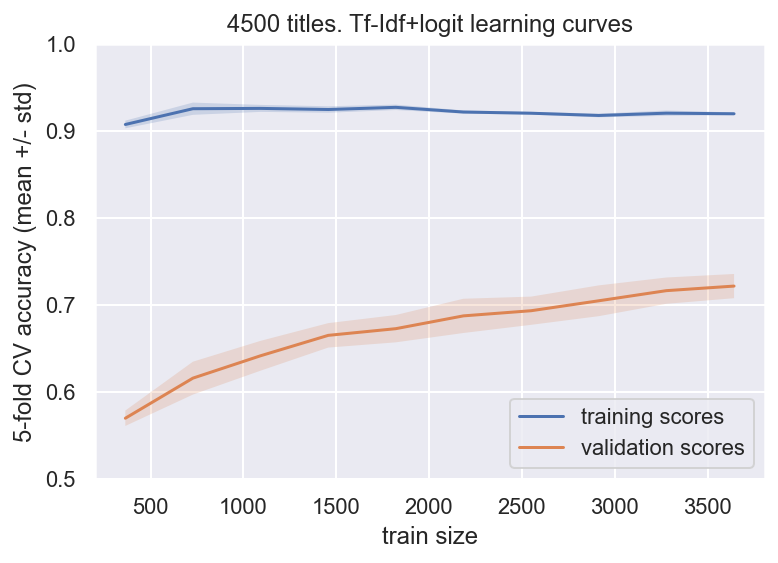

In [12]:
plot_with_err(train_sizes, train_scores, label='training scores')
plot_with_err(train_sizes, val_scores, label='validation scores')
plt.xlabel('train size')
plt.ylabel('5-fold CV accuracy (mean +/- std)')
plt.legend()
plt.grid(True);
plt.ylim(.5, 1)
plt.title('4500 titles. Tf-Idf+logit learning curves')
plt.savefig('../figures/20220408_learning_curves_baseline_model_4500_titles.png',
           dpi=300)